# Logistic Regression on Amazon Dataset Reviews

In [132]:
#import libraries.....
import time
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
import datetime
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import scipy as sp
from scipy import sparse
import tqdm
from prettytable import PrettyTable
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [133]:
# using the SQLite Table to read data.
# The below SQlite file consists of 60000 rows with Time based splitting and Summary column preprocessed[Feature Engineering].
con = sqlite3.connect('./final_tbs_cleansummary_text.sqlite')

final_tbs=pd.read_sql_query("""select * from Reviews""",con) # The table was preprocessed with time based splitting.
con.close()

final_tbs.head(5)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_Summary
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
1,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
2,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
3,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
4,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [134]:
def partition(x):
    if x == "positive":
        return 1
    return 0

actualScore = final_tbs['Score']
positiveNegative = actualScore.map(partition) 
final_tbs['Score'] = positiveNegative

final_tbs.head(5)


,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_Summary
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
1,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
2,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
3,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
4,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [135]:
#Since Summary column gives move details about what the text is, I joined both the features[Feature Engineering].
final_tbs['Summary_CleanedText'] = final_tbs[['Cleaned_Summary', 'CleanedText']].apply(lambda x: ' '.join(x), axis=1)

print(final_tbs['Summary_CleanedText'][0])

everi book educ witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg


In [136]:
# To plot confusion matrix.
def plot_confusion_matrix(y_test, pred):
    C = confusion_matrix(y_test, pred)
    
    labels = [1,2]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(10,4))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [137]:
# To print scores
def print_metrics_measure(pred,y_test):
    
     # Plotting Confusion_Matrix
    plot_confusion_matrix(y_test, pred)
    
    # evaluate accuracy
    acc = accuracy_score(y_test, pred) * 100
    print('\nThe accuracy of the LR [Test data] for lambda: ',(acc))
    
    # Precision
    precision = metrics.precision_score(y_test, pred)*100
    print('\nThe precision of the LR [Test data] for lambda: ',(precision))
    
    # Recall
    recall = metrics.recall_score(y_test, pred)*100
    print('\nThe recall of the LR [Test data] for lambda: ',(recall))
    
    #F1_Score
    f1_score = metrics.f1_score(y_test, pred)*100
    print('\nThe F1_score of the LR [Test data] for lambda: ',(f1_score))
    
    print("----"*20)

### Grid Search

In [138]:
def gridsearch(train_std_data,test_std_data,y_1,y_test):
    
    start=time.time()
    cv_scores = []
    tuned_parameters = [{'C': [0.001,0.01,0.1,1,10,100,1000], "penalty":["l1","l2"]}]
    k = StratifiedKFold(n_splits=5)
    grid_lr = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=k)
    grid_lr.fit(train_std_data,y_1)
    print("Best Estimator: ")
    model = grid_lr.best_estimator_
    print(model)
    print("******"*20)
    
    C = [0.001,0.01,0.1,1,10,100,1000]
    
    if grid_lr.best_params_['penalty'] == 'l1':
        cv_scores = (grid_lr.cv_results_['mean_train_score'][::2])
    else:
        cv_scores = (grid_lr.cv_results_['mean_train_score'][1::2])

    plt.plot(C, cv_scores)
    
    for xy in zip(C, np.round(cv_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
    plt.xlabel('Hyperparameters')
    plt.ylabel('cv_scores')
    plt.title("CV_SCORES of Trian")
    plt.grid()
    plt.show()
    
    #print("Best Hyperparameter is: ",grid_lr.best_params_['C'])
    
    
    if grid_lr.best_params_['penalty'] == 'l1':
        cv_scores = (grid_lr.cv_results_['mean_test_score'][::2])
    else:
        cv_scores = (grid_lr.cv_results_['mean_test_score'][1::2])

    plt.plot(C, cv_scores)
    
    for xy in zip(C, np.round(cv_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
        
    plt.xlabel('Hyperparameters')
    plt.ylabel('cv_scores')
    plt.title("CV_SCORES of Test")
    plt.grid()
    plt.show()
    
    #print("Best Hyperparameter is: ",grid_lr.best_params_['C'])
    
    print("******"*20)
    
    pred = grid_lr.predict(test_std_data)
    
    print_metrics_measure(pred,y_test)
    
    end=time.time()-start
    print(time.strftime("%H:%M:%S", time.gmtime(end)))
    return model

### Random Search

In [139]:
def randomsearch(train_std_data,test_std_data,y_1,y_test):
    
    start=time.time()
    C = []
    l1_count = []
    l2_count = []
    tuned_parameters={ 'C':[0.0001,0.001,0.01,0.1,1,10,100,1000,10000], 'penalty': ['l1', 'l2'] }
    k = StratifiedKFold(n_splits=5)
    random_lr = RandomizedSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=k)
    random_lr.fit(train_std_data,y_1)
    print("Best Estimator: ")
    model = random_lr.best_estimator_
    print(model)
    print("******"*20)
    
    # print(random_lr.cv_results_['params']) =>[{'penalty': 'l2', 'C': 0.0001}, {'penalty': 'l1', 'C': 0.1}, {'penalty': 'l1', 'C': 0.0001}, {'penalty': 'l2', 'C': 0.1}, {'penalty': 'l2', 'C': 0.01}, {'penalty': 'l2', 'C': 0.001}, {'penalty': 'l2', 'C': 10}, {'penalty': 'l2', 'C': 1000}, {'penalty': 'l1', 'C': 0.001}, {'penalty': 'l1', 'C': 100}]
    # params[0]['C'] => 0.0001
    # params[0]['penalty'] => 'l2'
    
    params = random_lr.cv_results_['params']
    for i in range(len(params)):
        if random_lr.best_params_['penalty'] == 'l1':
            if params[i]['penalty'] == 'l1':
                l1_count.append(i) # to store the indices which has penalty 'l1'
                C.append(params[i]['C']) 
                
        elif params[i]['penalty'] == 'l2':
            l2_count.append(i)  # to store the indices which has penalty 'l2'
            C.append(params[i]['C'])

    # print(C)
    # print(random_lr.cv_results_['mean_train_score']) => [0.92528491 0.92529661 0.92528491 0.92528491 0.92528491 0.92528491 0.94945413 0.97092593 0.92528491 0.97122726]
   
    # Train CV_scores
    if random_lr.best_params_['penalty'] == 'l1':
        cv_scores = (random_lr.cv_results_['mean_train_score'][l1_count])
    else:
        cv_scores = (random_lr.cv_results_['mean_train_score'][l2_count])

    plt.plot(C, cv_scores)
    
    for xy in zip(C, np.round(cv_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
    plt.xlabel('Hyperparameters')
    plt.ylabel('cv_scores')
    #print(cv_scores)
    plt.title("CV_SCORES of Trian")
    plt.grid()
    plt.show()
    
    # print("Best Hyperparameter is: ",random_lr.best_params_['C'])
    
    # Test CV_scores
    if random_lr.best_params_['penalty'] == 'l1':
        cv_scores_test = (random_lr.cv_results_['mean_test_score'][l1_count])
    else:
        cv_scores_test = (random_lr.cv_results_['mean_test_score'][l2_count])

    plt.plot(C, cv_scores_test)
    
    for xy in zip(C, np.round(cv_scores_test,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
        
    plt.xlabel('Hyperparameters')
    plt.ylabel('cv_scores')
    #print(cv_scores_test)
    plt.title("CV_SCORES of Test")
    plt.grid()
    plt.show()
    
    # print("Best Hyperparameter is: ",random_lr.best_params_['C'])
    
    print("******"*20)
    pred = random_lr.predict(test_std_data)
    
    print_metrics_measure(pred,y_test)
    
    end=time.time()-start
    print(time.strftime("%H:%M:%S", time.gmtime(end)))
    return model

In [140]:
# split the data set into train and test
y = np.array(final_tbs['Score'])

In [141]:
#Splitting whole data into Train,Cv,and Test datasets
# Using K-fold cross validation.
train_df, test_df, y_1, y_test = train_test_split(final_tbs, y, test_size=0.20, random_state=43,shuffle=False)

### BOW

In [142]:
#BoW
count_vect = CountVectorizer(min_df=50,max_features=2000) #in scikit-learn

train_bows = count_vect.fit_transform(train_df['Summary_CleanedText'])
test_bows = count_vect.transform(test_df['Summary_CleanedText'])

train_std_bow = normalize(train_bows, axis=0)
test_std_bow = normalize(test_bows, axis=0)
print(train_bows.shape)

(48000, 2000)


Best Estimator: 
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
************************************************************************************************************************


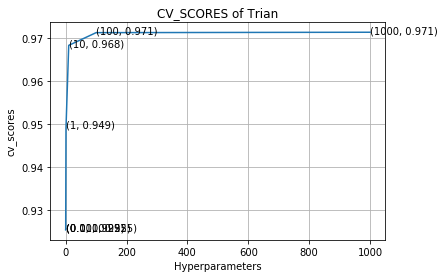

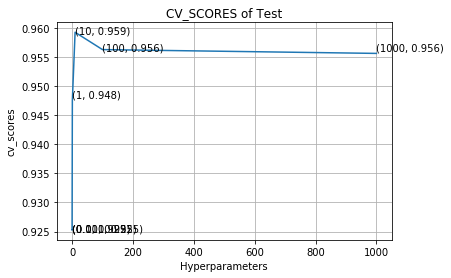

************************************************************************************************************************
-------------------- Confusion matrix --------------------


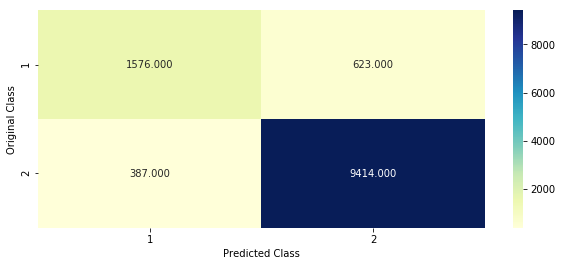


The accuracy of the LR [Test data] for lambda:  91.58333333333334

The precision of the LR [Test data] for lambda:  93.7929660257049

The recall of the LR [Test data] for lambda:  96.05142332415059

The F1_score of the LR [Test data] for lambda:  94.90876096380684
--------------------------------------------------------------------------------
00:00:33


In [143]:

lr_grid_bow = gridsearch(train_std_bow,test_std_bow,y_1,y_test)


Best Estimator: 
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
************************************************************************************************************************


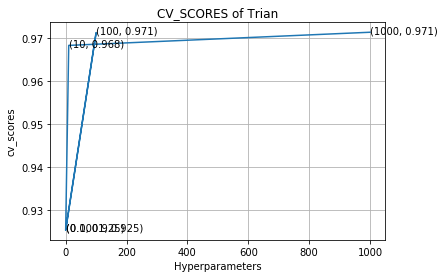

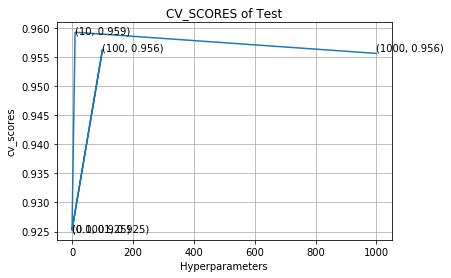

************************************************************************************************************************
-------------------- Confusion matrix --------------------


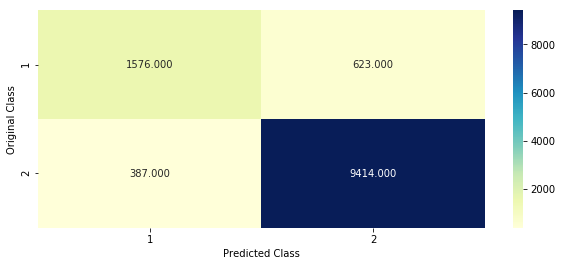


The accuracy of the LR [Test data] for lambda:  91.58333333333334

The precision of the LR [Test data] for lambda:  93.7929660257049

The recall of the LR [Test data] for lambda:  96.05142332415059

The F1_score of the LR [Test data] for lambda:  94.90876096380684
--------------------------------------------------------------------------------
00:00:18


In [144]:
#Random Search
lr_random_bow = randomsearch(train_std_bow,test_std_bow,y_1,y_test)


### Printing Top 100 Positive and Negative features.

In [145]:
def plot_wordcloud(text):
    # Create and generate a word cloud image:
    wordcloud = WordCloud(width = 1500, height = 600, 
                background_color ='white',  
                min_font_size = 10).generate(text) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show()

In [146]:
# coef_  --> Coefficient of the  features in the decision function.

# To check top 100 features after pertubation test.

def show_most_informative_features(vectorizer, clf, n=100):
    positive_text = ' '
    negative_text = ' '
    feature_names = vectorizer.get_feature_names()
    #print((clf.coef_[0][1999]))
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    #print(coefs_with_fns[:-11:-1])
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1),(coef_2, fn_2) in top:
        positive_text = positive_text + fn_2 + ' '
        negative_text = negative_text + fn_1 + ' '
    # To print positive words
    print("Positive Features: ")
    plot_wordcloud(positive_text)
    
    # To print negative words
    print("Negative Features: ")
    plot_wordcloud(negative_text)

Positive Features: 


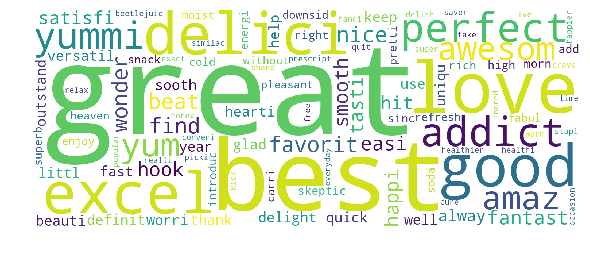

Negative Features: 


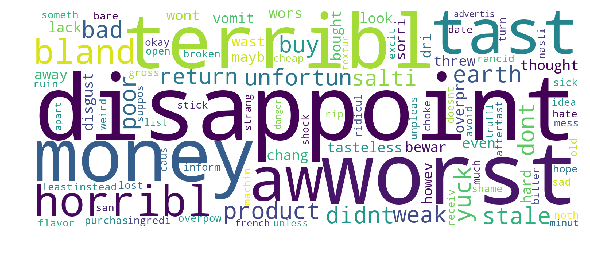

In [147]:
show_most_informative_features(count_vect, lr_grid_bow)

### TFIDF

In [149]:
tf_idf_vect = TfidfVectorizer(min_df=50,max_features=2000)

train_tfidf = tf_idf_vect.fit_transform(train_df['Summary_CleanedText'])
test_tfidf = tf_idf_vect.transform(test_df['Summary_CleanedText'])

train_std_tfidf = normalize(train_tfidf, axis=0)
test_std_tfidf = normalize(test_tfidf, axis=0)

train_tfidf.shape

(48000, 2000)

Best Estimator: 
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
************************************************************************************************************************


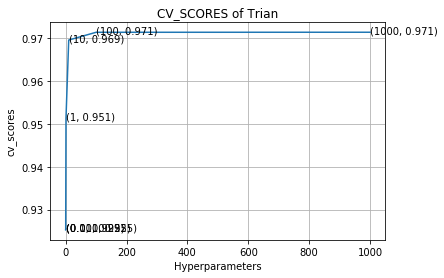

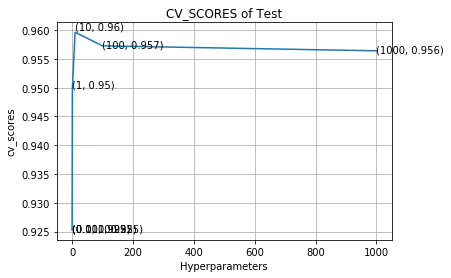

************************************************************************************************************************
-------------------- Confusion matrix --------------------


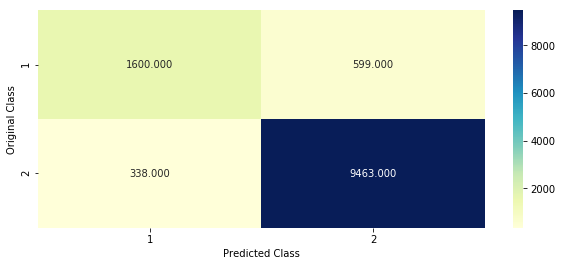


The accuracy of the LR [Test data] for lambda:  92.19166666666668

The precision of the LR [Test data] for lambda:  94.04690916318823

The recall of the LR [Test data] for lambda:  96.55137230894807

The F1_score of the LR [Test data] for lambda:  95.28268640185269
--------------------------------------------------------------------------------
00:00:35


In [150]:
# Grid Search
lr_grid_tfidf = gridsearch(train_std_tfidf,test_std_tfidf,y_1,y_test)


Best Estimator: 
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
************************************************************************************************************************


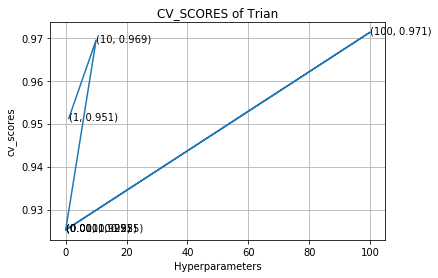

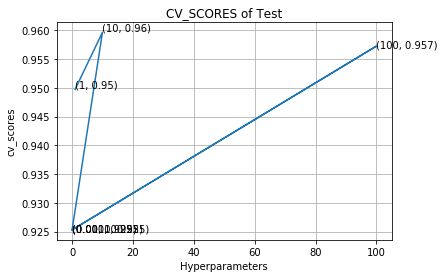

************************************************************************************************************************
-------------------- Confusion matrix --------------------


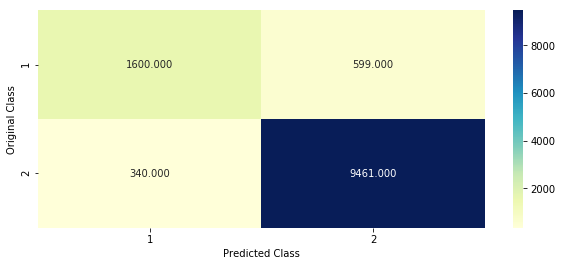


The accuracy of the LR [Test data] for lambda:  92.175

The precision of the LR [Test data] for lambda:  94.04572564612326

The recall of the LR [Test data] for lambda:  96.53096622793592

The F1_score of the LR [Test data] for lambda:  95.27214138260912
--------------------------------------------------------------------------------
00:00:21


In [151]:

lr_random_tfidf = randomsearch(train_std_tfidf,test_std_tfidf,y_1,y_test)


### Printing Top 100 Positive and Negative features.

Positive Features: 


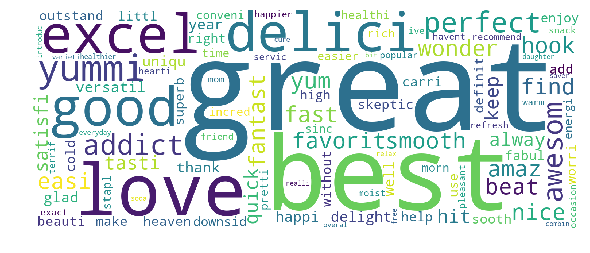

Negative Features: 


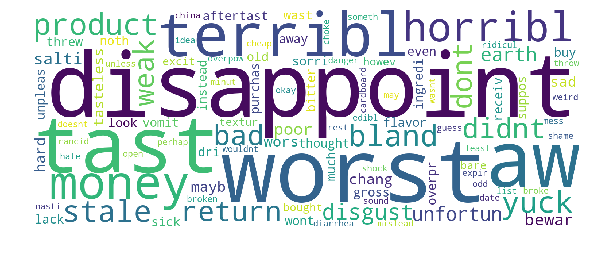

In [152]:
show_most_informative_features(tf_idf_vect, lr_grid_tfidf)

### Avg-W2V

In [153]:
# We have to train Word2Vec only by using train data.
def train_Word2Vec(list_of_sent):
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)
    return w2v_model,w2v_words

In [154]:

def avgw2v(list_of_sent,w2v_model,w2v_words):
    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors


In [155]:
start=time.time()

# Train your own Word2Vec model using your own text corpus
i=0
#train_sent_vectors=[]
#cv_sent_vectors=[]
#test_sent_vectors=[]

list_of_sent=[]
for sent in train_df['Summary_CleanedText'].values:
    list_of_sent.append(sent.split())
    
w2v_model,w2v_words = train_Word2Vec(list_of_sent)
train_sent_vectors = avgw2v(list_of_sent,w2v_model,w2v_words)

list_of_sent=[]
for sent in test_df['Summary_CleanedText'].values:
    list_of_sent.append(sent.split())

test_sent_vectors = avgw2v(list_of_sent,w2v_model,w2v_words)
    
end=time.time()-start
print(time.strftime("%H:%M:%S", time.gmtime(end)))

48000
50
12000
50
00:01:15


In [156]:
train_std_sent_vec = normalize(train_sent_vectors,axis=0)
test_std_sent_vec = normalize(test_sent_vectors,axis=0)

Best Estimator: 
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
************************************************************************************************************************


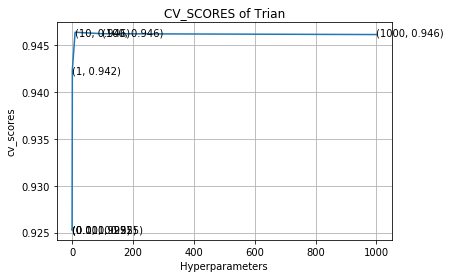

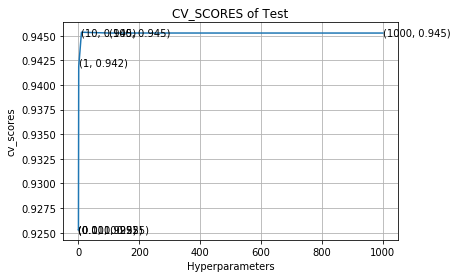

************************************************************************************************************************
-------------------- Confusion matrix --------------------


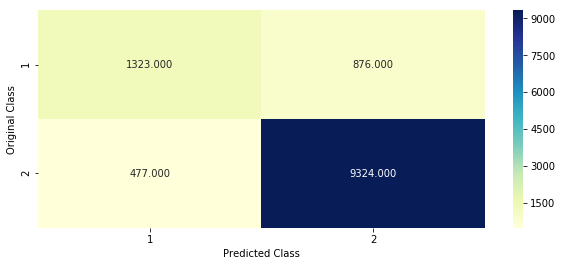


The accuracy of the LR [Test data] for lambda:  88.725

The precision of the LR [Test data] for lambda:  91.41176470588235

The recall of the LR [Test data] for lambda:  95.13314967860423

The F1_score of the LR [Test data] for lambda:  93.23533823308834
--------------------------------------------------------------------------------
00:03:10


In [157]:

lr_grid_avg_w2v = gridsearch(train_std_sent_vec,test_std_sent_vec,y_1,y_test)


Best Estimator: 
LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
************************************************************************************************************************


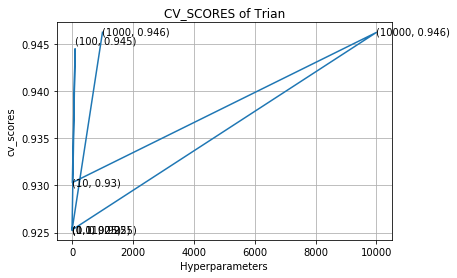

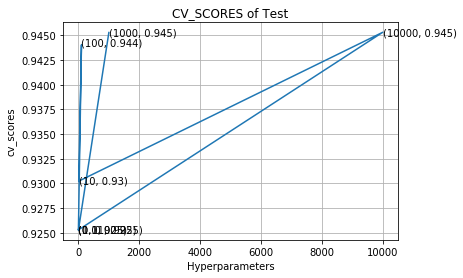

************************************************************************************************************************
-------------------- Confusion matrix --------------------


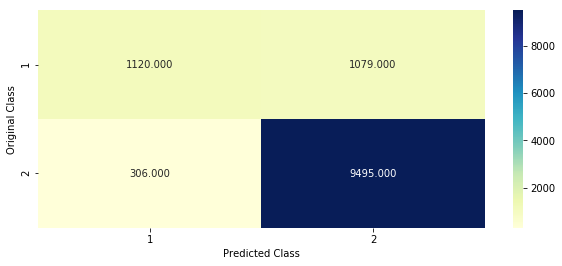


The accuracy of the LR [Test data] for lambda:  88.45833333333334

The precision of the LR [Test data] for lambda:  89.79572536410062

The recall of the LR [Test data] for lambda:  96.87786960514234

The F1_score of the LR [Test data] for lambda:  93.20245398773007
--------------------------------------------------------------------------------
00:01:38


In [158]:

lr_random_avg_w2v = randomsearch(train_std_sent_vec,test_std_sent_vec,y_1,y_test)


### TFIDF-W2V

In [159]:
#Only for train data

def train_Word2Vec(list_of_sent):
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)
    return w2v_model,w2v_words

def compute_tfidf(list_of_sent,w2v_words,dictionary):
    for sent in list_of_sent:
        for word in sent:
            if word in w2v_words:
                 tf_idf_train_data = dictionary[word]*(sent.count(word)/len(sent)) # Computing tfidf value only with train data.
    return tf_idf_train_data

In [160]:
def tfidf_w2v(list_of_sent,w2v_model,w2v_words,tf_idf):
    # TF-IDF weighted Word2Vec
    #model = TfidfVectorizer()
    #tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in list_of_sent: # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                #tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [161]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]

model = TfidfVectorizer()
start=time.time()

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in train_df['Summary_CleanedText'].values:
    list_of_sent.append(sent.split())
                        
tf_idf_matrix = model.fit_transform(train_df['Summary_CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

w2v_model,w2v_words = train_Word2Vec(list_of_sent)

tf_idf_train_data = compute_tfidf(list_of_sent,w2v_words,dictionary)

train_tfidf_w2v_vectors = tfidf_w2v(list_of_sent,w2v_model,w2v_words,tf_idf_train_data)

list_of_sent=[]
for sent in test_df['Summary_CleanedText'].values:
    list_of_sent.append(sent.split())
    
tf_idf_matrix = model.transform(test_df['Summary_CleanedText'].values)

test_tfidf_w2v_vectors = tfidf_w2v(list_of_sent,w2v_model,w2v_words,tf_idf_train_data)

end=time.time()-start
print(time.strftime("%H:%M:%S", time.gmtime(end)))


00:02:14


In [162]:
train_std_tfidfw2v = normalize(train_tfidf_w2v_vectors,axis=0)
test_std_tfidfw2v = normalize(test_tfidf_w2v_vectors,axis=0)

Best Estimator: 
LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
************************************************************************************************************************


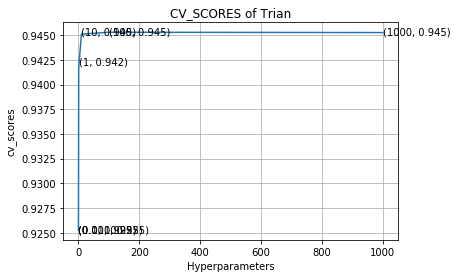

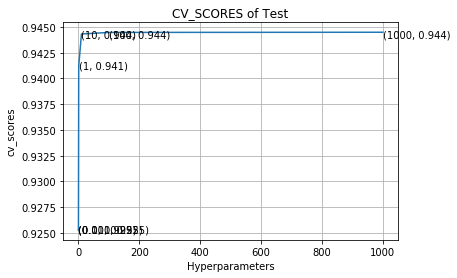

************************************************************************************************************************
-------------------- Confusion matrix --------------------


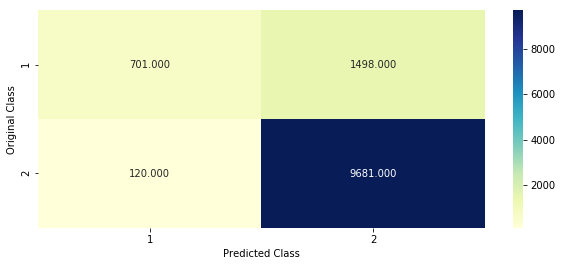


The accuracy of the LR [Test data] for lambda:  86.51666666666667

The precision of the LR [Test data] for lambda:  86.59987476518472

The recall of the LR [Test data] for lambda:  98.7756351392715

The F1_score of the LR [Test data] for lambda:  92.28789323164918
--------------------------------------------------------------------------------
00:03:11


In [163]:

lr_grid_tfidf_w2v = gridsearch(train_std_tfidfw2v,test_std_tfidfw2v,y_1,y_test)


Best Estimator: 
LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
************************************************************************************************************************


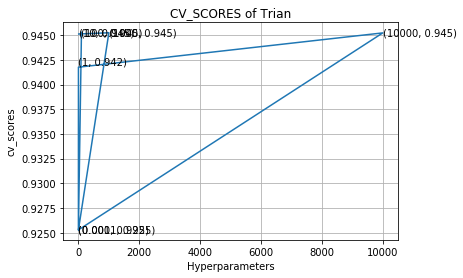

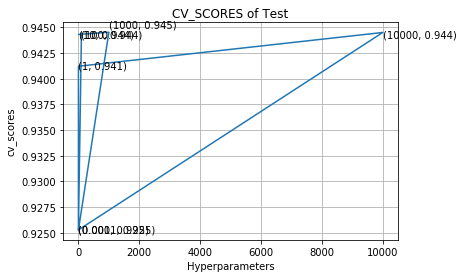

************************************************************************************************************************
-------------------- Confusion matrix --------------------


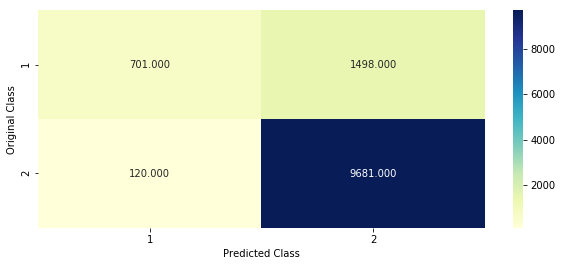


The accuracy of the LR [Test data] for lambda:  86.51666666666667

The precision of the LR [Test data] for lambda:  86.59987476518472

The recall of the LR [Test data] for lambda:  98.7756351392715

The F1_score of the LR [Test data] for lambda:  92.28789323164918
--------------------------------------------------------------------------------
00:04:19


In [164]:

lr_random_tfidf_w2v = randomsearch(train_std_tfidfw2v,test_std_tfidfw2v,y_1,y_test)


### Checking Sparsity by increasing C (C=1/lambda)

In [165]:
# If we increase lambda on L1 regularization,sparsity increases => useless features weights will be zero.
# 2000 -> max_features in tfidf
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

hyperparameters_graph = [0.0001,0.001,0.01,0.1,10,100,1000]
percentage_sparsity =[]

clf = LogisticRegression(C=0.0001, penalty='l1');
clf.fit(train_std_tfidf,y_1);
print("error for c=0.0001 is : ",(1-clf.score(test_std_tfidf, y_test))*100)
w = clf.coef_
print("Non Zero's: ",np.count_nonzero(w))
percentage_sparsity.append(((2000-np.count_nonzero(w))/2000)*100)
print("Percentage of sparsity :",((2000-np.count_nonzero(w))/2000)*100,"%")
print("*****************************************")

clf = LogisticRegression(C=0.001, penalty='l1');
clf.fit(train_std_tfidf,y_1);
print("error for c=0.001 is : ",(1-clf.score(test_std_tfidf, y_test))*100)
w = clf.coef_
print("Non Zero's: ",np.count_nonzero(w))
percentage_sparsity.append(((2000-np.count_nonzero(w))/2000)*100)
print("Percentage of sparsity :",((2000-np.count_nonzero(w))/2000)*100,"%")
print("*****************************************")

clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(train_std_tfidf,y_1);
print("error for c=0.01 is : ",(1-clf.score(test_std_tfidf, y_test))*100)
w = clf.coef_
print("Non Zero's: ",np.count_nonzero(w))
percentage_sparsity.append(((2000-np.count_nonzero(w))/2000)*100)
print("Percentage of sparsity :",((2000-np.count_nonzero(w))/2000)*100,"%")
print("*****************************************")

clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(train_std_tfidf,y_1);
print("error for c=0.1 is : ",(1-clf.score(test_std_tfidf, y_test))*100)
w = clf.coef_
print("Non Zero's: ",np.count_nonzero(w))
percentage_sparsity.append(((2000-np.count_nonzero(w))/2000)*100)
print("Percentage of sparsity :",((2000-np.count_nonzero(w))/2000)*100,"%")
print("*****************************************")

clf = LogisticRegression(C=10, penalty='l1');
clf.fit(train_std_tfidf,y_1);
print("error for c=10 is : ",(1-clf.score(test_std_tfidf, y_test))*100)
w = clf.coef_
print("Non Zero's: ",np.count_nonzero(w))
percentage_sparsity.append(((2000-np.count_nonzero(w))/2000)*100)
print("Percentage of sparsity :",((2000-np.count_nonzero(w))/2000)*100,"%")
print("*****************************************")

clf = LogisticRegression(C=100, penalty='l1');
clf.fit(train_std_tfidf,y_1);
print("error for c=100 is : ",(1-clf.score(test_std_tfidf, y_test))*100)
w = clf.coef_
print("Non Zero's: ",np.count_nonzero(w))
percentage_sparsity.append(((2000-np.count_nonzero(w))/2000)*100)
print("Percentage of sparsity :",((2000-np.count_nonzero(w))/2000)*100,"%")
print("*****************************************")

clf = LogisticRegression(C=1000, penalty='l1');
clf.fit(train_std_tfidf,y_1);
print("error for c=1000 is : ",(1-clf.score(test_std_tfidf, y_test))*100)
w = clf.coef_
print("Non Zero's: ",np.count_nonzero(w))
percentage_sparsity.append(((2000-np.count_nonzero(w))/2000)*100)
print("Percentage of sparsity :",((2000-np.count_nonzero(w))/2000)*100,"%")
print("*****************************************")


error for c=0.0001 is :  18.325000000000003
Non Zero's:  0
Percentage of sparsity : 100.0 %
*****************************************
error for c=0.001 is :  18.325000000000003
Non Zero's:  0
Percentage of sparsity : 100.0 %
*****************************************
error for c=0.01 is :  18.325000000000003
Non Zero's:  0
Percentage of sparsity : 100.0 %
*****************************************
error for c=0.1 is :  17.774999999999995
Non Zero's:  9
Percentage of sparsity : 99.55000000000001 %
*****************************************
error for c=10 is :  7.825000000000005
Non Zero's:  1534
Percentage of sparsity : 23.3 %
*****************************************
error for c=100 is :  8.216666666666672
Non Zero's:  1939
Percentage of sparsity : 3.05 %
*****************************************
error for c=1000 is :  8.274999999999999
Non Zero's:  1992
Percentage of sparsity : 0.4 %
*****************************************


### PLotting graph between Hyperparameters and Percentage of Sparsity

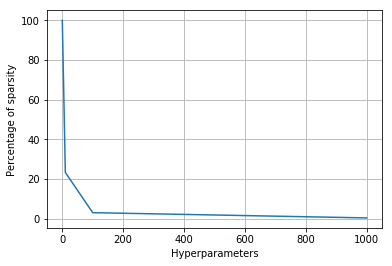

In [166]:
plt.plot(hyperparameters_graph, percentage_sparsity)
plt.xlabel('Hyperparameters')
plt.ylabel('Percentage of sparsity')
plt.grid()

### Below code snippets are to check for multicollinearity betwen features.

### Pertubation Test

In [167]:
def Logistic_Regression(train_std_data, y_1):
    start=time.time()
    alpha_values = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
    cv_scores=[]
    for alpha in alpha_values:
        clf = LogisticRegression(C=alpha)  
        scores = cross_val_score(clf, train_std_data, y_1, cv=10,scoring="f1")   
        clf.fit(train_std_data, y_1)
        cv_scores.append(scores.mean())
        
    # MSE = [1-x for x in cv_scores] # Misclassification error
    print(cv_scores)
    optimal_alpha = alpha_values[cv_scores.index(max(cv_scores))]
    print('\nThe optimal number of alpha is %f.' % optimal_alpha)
    
    # plot misclassification error vs k 
    plt.plot(alpha_values, cv_scores)
    
    for xy in zip(alpha_values, np.round(cv_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
    plt.xlabel('Hyperparameters')
    plt.ylabel('cv_scores')
    plt.show()
    
    print("the cv_scores for each alpha value is : ", np.round(cv_scores,3))
    
    LR_optimal = LogisticRegression(C=optimal_alpha)
    
    # fitting the model
    LR_optimal.fit(train_std_data, y_1)   
    return LR_optimal,optimal_alpha

[0.9252849167431967, 0.9252849167431967, 0.9252849167431967, 0.9252849167431967, 0.9262132170474592, 0.9512281068035563, 0.9585483125903741, 0.9582973639109156]

The optimal number of alpha is 100.000000.


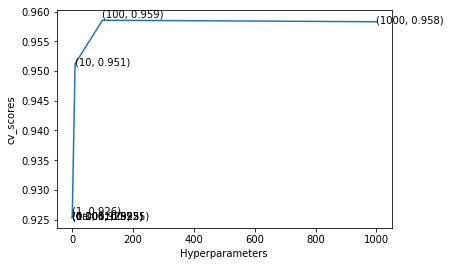

the cv_scores for each alpha value is :  [0.925 0.925 0.925 0.925 0.926 0.951 0.959 0.958]


In [168]:
# Training the model before pertubation test. 
# Chose TFIDF features to check for multicollinearity.
# C=0.1 -> we have already tuned the hyperparameter for the data{randomsearchCV}.

#model=LogisticRegression(C=0.1)
#model.fit(train_std_tfidf,y_1);
#weights=grid_tfidf.classes_
#print(weights)
#np.sort(weights)

model,hyperparameter = Logistic_Regression(train_std_tfidf,y_1)
weights = model.coef_

In [169]:
# coef_  --> Coefficient of the  features in the decision function.

# To check top 10 features after pertubation test.

x = PrettyTable()

x.field_names = ["coef_", "Feature"]

def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    #print(sorted(clf.coef_[0]))
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    #print(coefs_with_fns[:-11:-1])
    #top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    top = coefs_with_fns[:-(n + 1):-1]
    for i,(coef_1, fn_1) in enumerate(top):
        x.add_row([coef_1,fn_1])
        #print("\t%.4f\t%-15s\t" %(coef_1, fn_1))
    print(x)
        
show_most_informative_features(tf_idf_vect, model)

+--------------------+---------+
|       coef_        | Feature |
+--------------------+---------+
| 132.7648082536768  |  great  |
|  97.5587230282755  |   best  |
| 97.34954750738586  |   love  |
| 79.22170548458828  |  delici |
| 71.65596579558948  |  excel  |
| 69.58885382355959  |   good  |
| 55.777030022595056 | perfect |
| 48.91975904615182  |  yummi  |
| 45.88322856840687  |   find  |
| 45.730683716798744 |  addict |
+--------------------+---------+


In [170]:
# converting data from sparse matrix to array inorder to add small value[Pertubation test].

data=train_std_tfidf
data=data.toarray()

In [171]:
# tf_idf_vect.max_features:2000 {It was defined at the time of tfidf featurization.}
# Adding small value to the data where there are nonzero's
start=time.time()

for i in range(train_std_tfidf.shape[0]):
    for j in range(tf_idf_vect.max_features):
        if data[i][j]!=0:
            data[i][j]=data[i][j]+np.random.normal(0, 0.001)
            
end=time.time()-start
print(time.strftime("%H:%M:%S", time.gmtime(end)))

# modified_data=[data[i][j]+np.random.normal(0, 0.01) for i in range((train_std_tfidf.shape[0])) for j in range(2000) if data[i][j]!=0]

00:01:05


In [172]:
# To convert from array to csr_matrix.
train_std_tfidf_modified = sparse.csr_matrix(data)
# train_std_tfidf_modified

In [173]:
# After adding little values again we are training the model.

model_modified=LogisticRegression(C=hyperparameter)
model_modified.fit(train_std_tfidf_modified,y_1);
weights1=model_modified.coef_
#print(weights1)
#np.sort(weights1)

In [174]:
# coef_  --> Coefficient of the  features in the decision function.

# To check top 10 features after pertubation test.

x = PrettyTable()

x.field_names = ["coef_", "Feature"]

def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    #print((clf.coef_[0][1999]))
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    #print(coefs_with_fns[:-11:-1])
    #top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    top = coefs_with_fns[:-(n + 1):-1]
    for i,(coef_1, fn_1) in enumerate(top):
        x.add_row([coef_1,fn_1])
        #print("\t%.4f\t%-15s\t" %(coef_1, fn_1))
    print(x)
        
show_most_informative_features(tf_idf_vect, model_modified)

+--------------------+---------+
|       coef_        | Feature |
+--------------------+---------+
| 129.29496122874826 |  great  |
| 97.28627820190798  |   love  |
| 96.96958584687646  |   best  |
| 78.60683051771292  |  delici |
| 70.99842846562919  |  excel  |
| 68.32387048289593  |   good  |
| 55.93650084579836  | perfect |
| 49.032783714666856 |  yummi  |
| 45.71468318823945  |   find  |
| 45.626835958073194 |  addict |
+--------------------+---------+


In [175]:
pct_change=[(np.absolute((a - b)+0.00001/(a+0.00001)))*100 for a, b in zip(weights[::1], weights1[::1])]
print(len(pct_change))
print(type(pct_change))

1
<class 'list'>


In [176]:
pct_change1 = pct_change
pct_change1 = np.array(pct_change1).T

<class 'numpy.ndarray'>


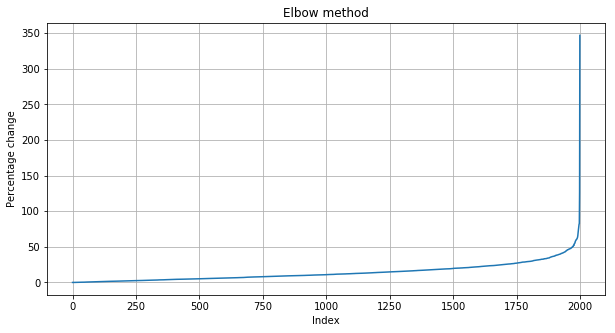

In [177]:

print(type(pct_change1))
#pct_change1 =(pct_change1[:][-1])
plt.figure(figsize=(10,5))
plt.plot((range(len(pct_change1))),list(sorted(pct_change1,reverse=False)))
plt.xlabel("Index")
plt.ylabel("Percentage change")
plt.title("Elbow method")
plt.grid()

In [178]:
'''a=[]
#for i in range(1):
for j in range(2000):        
    if(pct_change[0][j]>=20):
        a.append(j)
        print("Feature:",j,"->",pct_change[0][j])
        
i=0;
for key,value in tf_idf_vect.vocabulary_.items():
    for i in range(len(a)):
        if(value==a[i]):
            print(value,"->",key)
        
#Below results are: index->key->Percentage change in between weights after pertubation test.

for j in range(tf_idf_vect.max_features):
    if(pct_change[0][j]>=30): # if percentage change is greater than or equal to 'x' percentage, then print the values. 
        for key,value in tf_idf_vect.vocabulary_.items():
            if(value==j):
                print("Feature:",value," -> ",key," -> ",pct_change[0][j]) 
'''                
#from prettytable import PrettyTable  

x = PrettyTable()

x.field_names = ["Feature Index(Value)", "Feature(Key)", "Percentage weight change"]

for j in range(tf_idf_vect.max_features):
    if(pct_change[0][j]>=60): # if percentage change is greater than or equal to 'x' percentage, then print the values. 
        for key,value in tf_idf_vect.vocabulary_.items():
            if(value==j):
                x.add_row([value,key,pct_change[0][j]])
                #print("Feature:",value," -> ",key," -> ",pct_change[0][j]) 
                
print(x)                

+----------------------+--------------+--------------------------+
| Feature Index(Value) | Feature(Key) | Percentage weight change |
+----------------------+--------------+--------------------------+
|         232          |     buy      |    77.96823094969193     |
|         247          |    candi     |    60.32122766292603     |
|         458          |    delici    |    61.48750931033787     |
|         543          |     eat      |     82.5206925439282     |
|         587          |    excel     |    65.75374695159934     |
|         746          |     good     |    126.4983484364815     |
|         766          |    great     |    346.98471002496854    |
|         806          |     hard     |    60.80822069339049     |
|         921          |     ive      |    62.495028647590814    |
|         1192         |     old      |    81.86564907719483     |
|         1197         |     one      |    70.13056185638715     |
|         1388         |     raw      |    60.011954831654016 

## Conclusion:

In [180]:
x = PrettyTable()

x.field_names = ["Vectorizer", "CV", "Hyperparameter(C)", "Accuracy", "Precision", "Recall", "F1_Score"]
x.add_row(["BOW", "Grid Search",10,91.58,93.79,96.05,94.90])
x.add_row(["BOW", "Random Search",10,91.58,93.79,96.05,94.90])
x.add_row(["TFIDF", "Grid Search",10,92.19,94.04,96.55,95.28])
x.add_row(["TFIDF", "Random Search",10,91.175,94.457,96.5309,95.2721])
x.add_row(["AVG-W2V", "Grid Search",1000,88.725,91.411,95.1331,93.2353])
x.add_row(["AVG-W2V", "Random Search",10000,88.4583,91.7957,94.8778,93.2024])
x.add_row(["TFIDF-W2V", "Grid Search",1000,86.5166,86.5998,98.7756,92.2878])
x.add_row(["TFIDF-W2V", "Random Search",1000,86.5166,86.5998,98.7756,92.2878])
print(x)

+------------+---------------+-------------------+----------+-----------+---------+----------+
| Vectorizer |       CV      | Hyperparameter(C) | Accuracy | Precision |  Recall | F1_Score |
+------------+---------------+-------------------+----------+-----------+---------+----------+
|    BOW     |  Grid Search  |         10        |  91.58   |   93.79   |  96.05  |   94.9   |
|    BOW     | Random Search |         10        |  91.58   |   93.79   |  96.05  |   94.9   |
|   TFIDF    |  Grid Search  |         10        |  92.19   |   94.04   |  96.55  |  95.28   |
|   TFIDF    | Random Search |         10        |  91.175  |   94.457  | 96.5309 | 95.2721  |
|  AVG-W2V   |  Grid Search  |        1000       |  88.725  |   91.411  | 95.1331 | 93.2353  |
|  AVG-W2V   | Random Search |       10000       | 88.4583  |  91.7957  | 94.8778 | 93.2024  |
| TFIDF-W2V  |  Grid Search  |        1000       | 86.5166  |  86.5998  | 98.7756 | 92.2878  |
| TFIDF-W2V  | Random Search |        1000       |